In [1]:
from utilities import objectview, setup_logging, set_seed
from model import SimpleClassifier
from dataset import VQADataset
from torch.utils.data import DataLoader
import yaml
import os
import argparse
import torch
from torch import nn
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt


2023-04-16 02:01:01.256173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 02:01:01.983929: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/amrit/.mujoco/mujoco200/bin:/usr/lib/nvidia
2023-04-16 02:01:01.983978: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/amrit/.mujoco/mujoco200/bin:/usr/lib/nvidia
2023-04-16 02:01:01.983983: 

In [ ]:

config_path = "/home/amrit/Downloads/Spring2023/pipeline/in_progress/medVQA/NLP-CS7650-Project/config.yaml" 

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
config = objectview(config)
config.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class model_trainer():
    def __init__(self , config):
        
        self.config = config
        
        train_ds = VQADataset(config, type = "train")
        val_ds = VQADataset(config, type = "val")
        test_ds = VQADataset(config, type = "test")
        self.device='cuda:0'
        self.train_dataloader = DataLoader(train_ds, batch_size=128, shuffle=True)
        self.val_dataloader = DataLoader(val_ds, batch_size=128, shuffle=False)
        self.test_dataloader = DataLoader(test_ds, batch_size=128, shuffle=False)

        # model and optimizer -- add these to config to run experiments easily
        self.model = SimpleClassifier().to(config.device)
        # self.model = SANModel().to(config.device)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.num_epochs = config.epochs
        self.run_id = config.run_id
        # setup logging and the results directory for the current run
        self.writer, self.best_model_path = setup_logging(config)

        self.save_path_model = 'save_path' +'best.pth'
        
        
        self.best_val_accuracy = 0.0
        self.best_val_f1 = 0.0

        self.train_gtlist= None
        self.val_gtlist =  None
        self.test_gtlist= None
        
        self.train_predlist =  None
        self.val_predlist =  None
        self.test_predlist =  None

     
    
    def single_epoch_train(self, dataloader):
        running_loss_train = 0.0
        gtLabelsList = []
        predictedLabelsList = []
        idx_list = []

        self.model.train()
        for i, data in enumerate(dataloader):
            inputImg, inputTxt, labels, idx = data

            # print(inputImg.shape, inputTxt.shape)

            self.optimizer.zero_grad()
            outputs = self.model(inputImg.to(self.device), inputTxt.to(self.device)).squeeze()
            labels = labels.to(self.device).squeeze()
            
            loss_train = self.criterion(outputs, labels)
            loss_train.backward()
            self.optimizer.step()

            running_loss_train += loss_train.item()

            outputLabels = torch.argmax(outputs, dim=1)

            idx_list.extend(list(idx.detach().cpu().numpy()))
            predictedLabelsList.extend(list(outputLabels.detach().cpu().numpy()))
            gtLabelsList.extend(list(labels.detach().cpu().numpy()))
        
        running_loss_train = running_loss_train/len(dataloader)

        return  running_loss_train , gtLabelsList , predictedLabelsList , idx_list

    def get_metrics(self , pred ,gt ):
        predlist = pred.copy()
        gtlist = gt.copy()
        
        f1 = f1_score(predlist, gtlist, average = 'micro')
        accuracy = accuracy_score(predlist, gtlist,)
        return accuracy , f1 
    
    def single_epoch_val(self, dataloader , val_mode = None):
        running_loss_val = 0.0
        gtLabelsList = []
        predictedLabelsList = []
        idx_list = []

        self.model.eval()
        with torch.no_grad():
            for i, data in enumerate(dataloader):
                # inputImg, inputTxt, labels = data
                
                inputImg, inputTxt, labels , idx= data

                if val_mode == 'image_ablation':
                    inputImg = -1* torch.ones(size=inputImg.shape).to(self.device)
                elif val_mode == 'text_ablation':
                    inputTxt = -1* torch.ones(size=inputTxt.shape).to(self.device)
                    # inputTxt = torch.rand(size=inputTxt.shape).to(self.device)


                outputs = self.model(inputImg, inputTxt).squeeze()
                outputLabels = torch.argmax(outputs, dim=1)
                # loss_val = self.criterion(outputs, labels)
                # running_loss_val += loss_val.item()

                idx_list.extend(list(idx.detach().cpu().numpy()))
                predictedLabelsList.extend(list(outputLabels.detach().cpu().numpy()))
                gtLabelsList.extend(list(labels.detach().cpu().numpy()))
            
            # print(gtLabelsList)
        # running_loss_val = running_loss_val/(len(dataloader))
        return gtLabelsList , predictedLabelsList , idx_list
    
    def load_model(self):
        checkpoint = torch.load('/content/vqa_rad/biomed_roberta_convnext/runs/11/models/best.pth')
        self.model.load_state_dict(checkpoint['model_state_dict'])

    def generate_report(self, gt , pred):
        from sklearn.metrics import classification_report
        return classification_report(gt, pred ,output_dict=True)
    

       
    def train(self,max_epochs=10 , test_mode = None):

        train_acc_list = []
        val_acc_list = []
        test_acc_list = []
        
        for epoch in range(max_epochs):
            train_loss , train_gtlist , train_predlist, train_idx_list = self.single_epoch_train(dataloader = self.train_dataloader)
            val_gtlist , val_predlist , val_idx_list = self.single_epoch_val(dataloader = self.val_dataloader ,
                                                                             val_mode = test_mode)
            test_gtlist , test_predlist , test_idx_list  = self.single_epoch_val(dataloader = self.test_dataloader,
                                                                                 val_mode = test_mode)
            
            if self.train_gtlist == None:
                self.train_gtlist = train_gtlist
                self.train_idx = train_idx_list
            if self.val_gtlist == None:
                self.val_gtlist = val_gtlist
                self.val_idx = val_idx_list
            if self.test_gtlist == None:
                self.test_gtlist = test_gtlist
                self.test_idx = test_idx_list

            self.val_predlist = val_predlist
            self.train_predlist = train_predlist    
            self.test_predlist = test_predlist    

            train_accuracy , train_f1  = self.get_metrics(train_predlist ,train_gtlist )
            val_accuracy , val_f1  = self.get_metrics(val_predlist ,val_gtlist )
            test_accuracy , test_f1  = self.get_metrics(test_predlist ,test_gtlist )
            
            train_acc_list.append(train_accuracy)
            val_acc_list.append(val_accuracy)
            test_acc_list.append(test_accuracy)

            if(val_f1 > self.best_val_f1):
                self.best_val_f1 = val_f1

            if(val_accuracy > self.best_val_accuracy):
                # self.val_predlist = val_predlist
                # self.train_predlist = train_predlist
                # # self.val_pred_list = val_predlist

                self.best_val_accuracy = val_accuracy
                torch.save({
                  'epoch': epoch,
                  'model_state_dict': self.model.state_dict(),
                  'optimizer_state_dict': self.optimizer.state_dict(),
                  'train_loss': train_loss,
                  'train_accuracy':train_accuracy,
                  'val_accuracy':val_accuracy,
                  'val_f1': val_f1, 
                  }, self.save_path_model)

            self.writer.add_scalar("Loss/train", train_loss/len(self.train_dataloader), epoch)
            self.writer.add_scalar("Accuracy/train", train_accuracy , epoch)
            self.writer.add_scalar("F1/train", train_f1 , epoch)

            print(f"EPOCH:{epoch} TRAIN f1:{train_f1:.2f}, acc:{train_accuracy:.2f} Val f1:{val_f1:.2f}, acc:{val_accuracy:.2f} Test f1:{test_f1:.2f}, acc:{test_accuracy:.2f}")
            
        print('Training finished')
        print(f"Best F1 Train score:{self.best_val_accuracy:.2f}")
        print(f"Best Acc Train score:{self.best_val_accuracy:.2f}")

        return  train_acc_list , val_acc_list, test_acc_list
            
trainer = model_trainer(config )
train_acc_list , val_acc_list , test_acc_list = trainer.train(max_epochs=20)

# Ablation of Image/Text components

Loading : ./data/cache/train.pkl
Language model embeddings already exist
Vision model embeddings already exist
Loading : ./data/cache/val.pkl
Language model embeddings already exist
Vision model embeddings already exist
Loading : ./data/cache/test_target.pkl
Language model embeddings already exist
Vision model embeddings already exist
EPOCH:0 TRAIN f1:0.27, acc:0.27 Val f1:0.32, acc:0.32 Test f1:0.31, acc:0.31
EPOCH:1 TRAIN f1:0.34, acc:0.34 Val f1:0.39, acc:0.39 Test f1:0.28, acc:0.28
EPOCH:2 TRAIN f1:0.37, acc:0.37 Val f1:0.42, acc:0.42 Test f1:0.32, acc:0.32
EPOCH:3 TRAIN f1:0.39, acc:0.39 Val f1:0.39, acc:0.39 Test f1:0.36, acc:0.36
EPOCH:4 TRAIN f1:0.45, acc:0.45 Val f1:0.44, acc:0.44 Test f1:0.39, acc:0.39
EPOCH:5 TRAIN f1:0.48, acc:0.48 Val f1:0.45, acc:0.45 Test f1:0.41, acc:0.41
EPOCH:6 TRAIN f1:0.53, acc:0.53 Val f1:0.49, acc:0.49 Test f1:0.42, acc:0.42
EPOCH:7 TRAIN f1:0.60, acc:0.60 Val f1:0.49, acc:0.49 Test f1:0.47, acc:0.47
EPOCH:8 TRAIN f1:0.66, acc:0.66 Val f1:0.55, ac

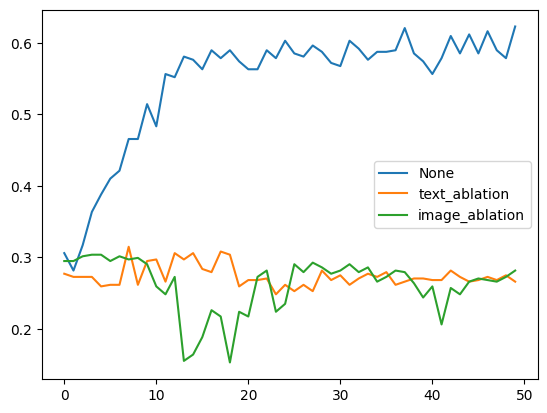

In [90]:
mode_list = ['None' , 'text_ablation' , 'image_ablation' ]

pred_list = []
for test_mode in mode_list:
    trainer = model_trainer(config )
    train_acc_list , val_acc_list , test_acc_list = trainer.train(max_epochs=50,  test_mode=test_mode)
    pred_list.append([train_acc_list , val_acc_list , test_acc_list])
    plt.plot(test_acc_list )

plt.legend(mode_list)

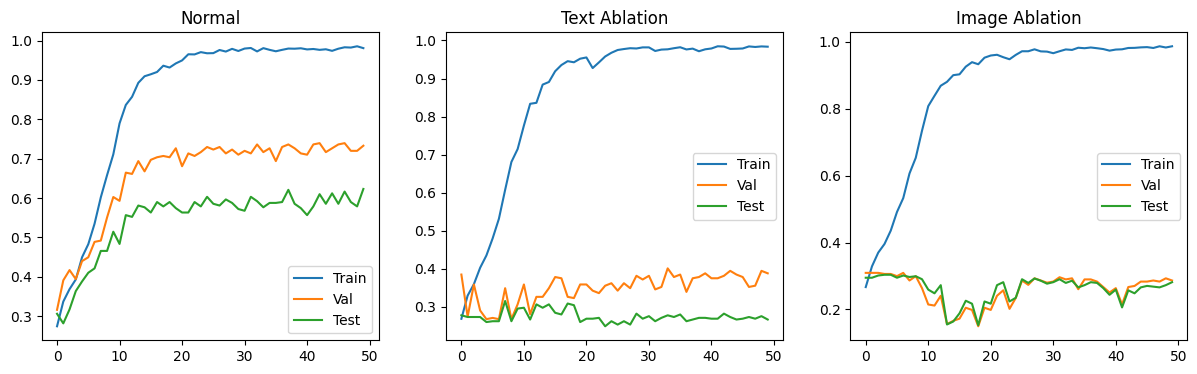

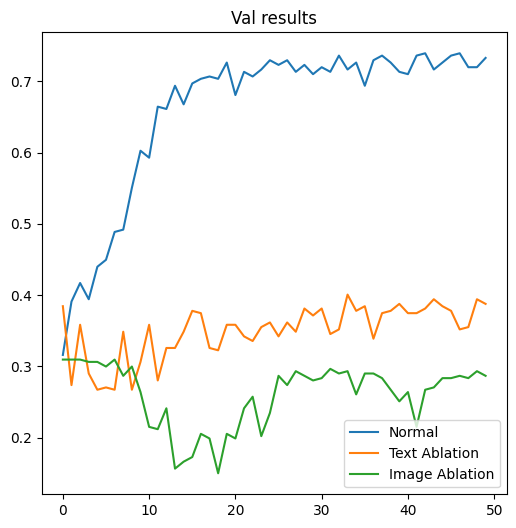

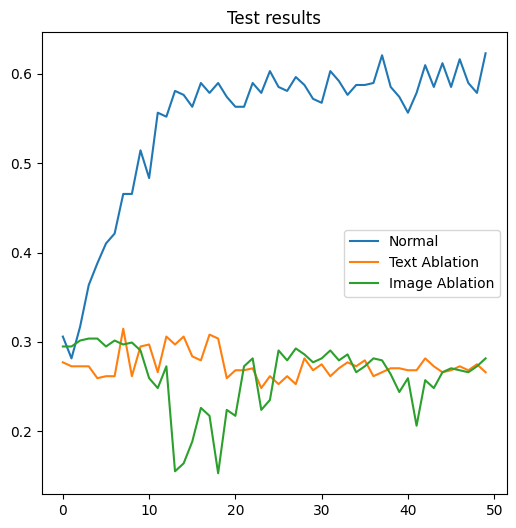

In [98]:
plt.figure(figsize=(20,4))

plt.subplot(1,4,1)
plt.plot(pred_list[0][0])
plt.plot(pred_list[0][1])
plt.plot(pred_list[0][2])
plt.title("Normal")
plt.legend(['Train' , 'Val' , 'Test'])

plt.subplot(1,4,2)
plt.plot(pred_list[1][0])
plt.plot(pred_list[1][1])
plt.plot(pred_list[1][2])
plt.title("Text Ablation")
plt.legend(['Train' , 'Val' , 'Test'])

plt.subplot(1,4,3)
plt.plot(pred_list[2][0])
plt.plot(pred_list[2][1])
plt.plot(pred_list[2][2])
plt.title("Image Ablation")
plt.legend(['Train' , 'Val' , 'Test'])
plt.show()
# plt.subplot(1,4,4)
plt.figure(figsize=(6,6))
plt.plot(pred_list[0][1])
plt.plot(pred_list[1][1])
plt.plot(pred_list[2][1])
plt.title("Val results")
plt.legend(['Normal' , 'Text Ablation' , 'Image Ablation'])
plt.show()

plt.figure(figsize=(6,6))
plt.plot(pred_list[0][2])
plt.plot(pred_list[1][2])
plt.plot(pred_list[2][2])
plt.title("Test results")
plt.legend(['Normal' , 'Text Ablation' , 'Image Ablation'])
plt.show()


# Error analysis

In [80]:
train_predList = trainer.train_predlist
train_gtlist = trainer.train_gtlist

val_gtlist = trainer.val_gtlist
val_predlist = trainer.val_predlist
val_idx = trainer.val_idx


In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 250)
pd.set_option('display.width', 1000)

label_open_df = pd.read_pickle("/home/amrit/Downloads/Spring2023/pipeline/in_progress/medVQA/NLP-CS7650-Project/data/cache/trainval_label2ans.pkl")
# label_open_df = pd.read_pickle("/home/amrit/Downloads/Spring2023/pipeline/in_progress/medVQA/NLP-CS7650-Project/data/cache/open_label2ans.pkl")
label_open_df

def get_labels(x):
    return label_open_df[x]

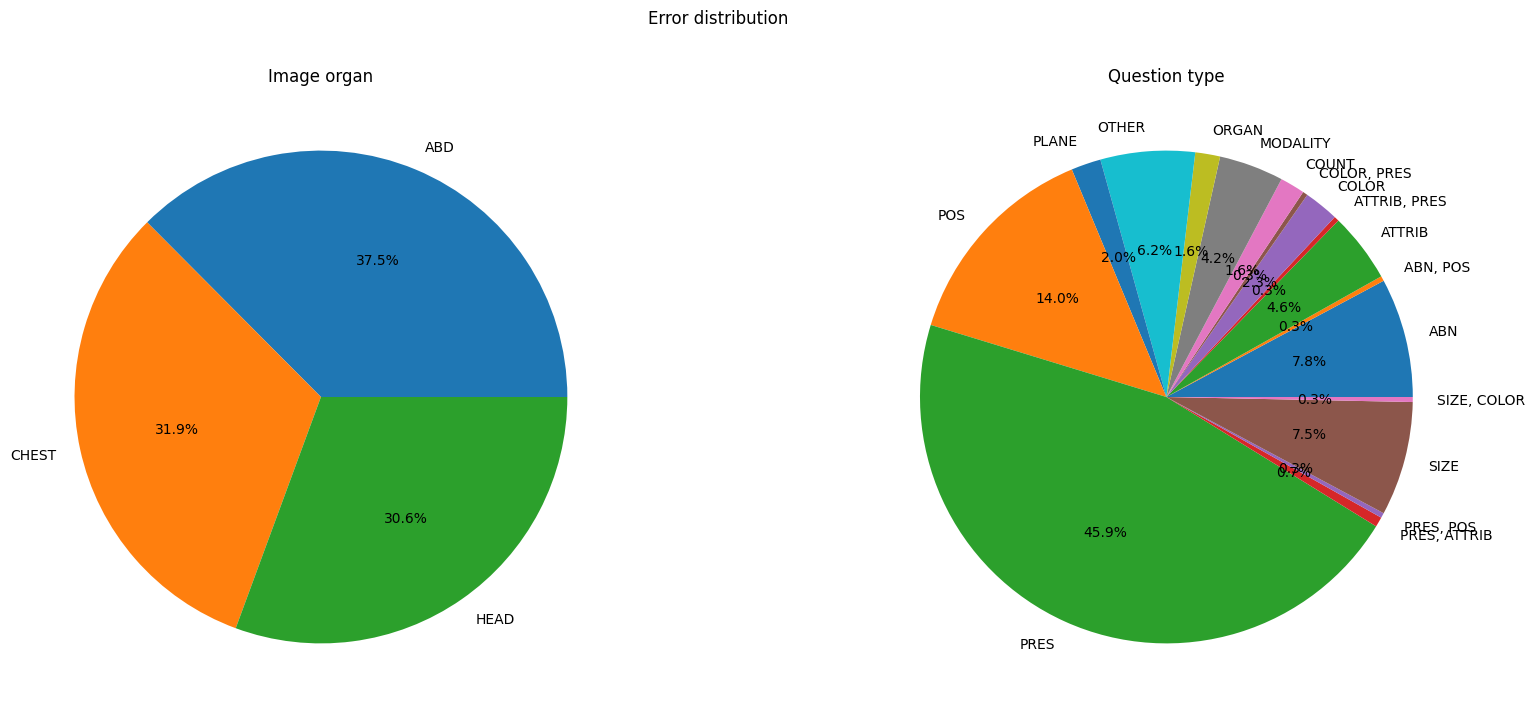

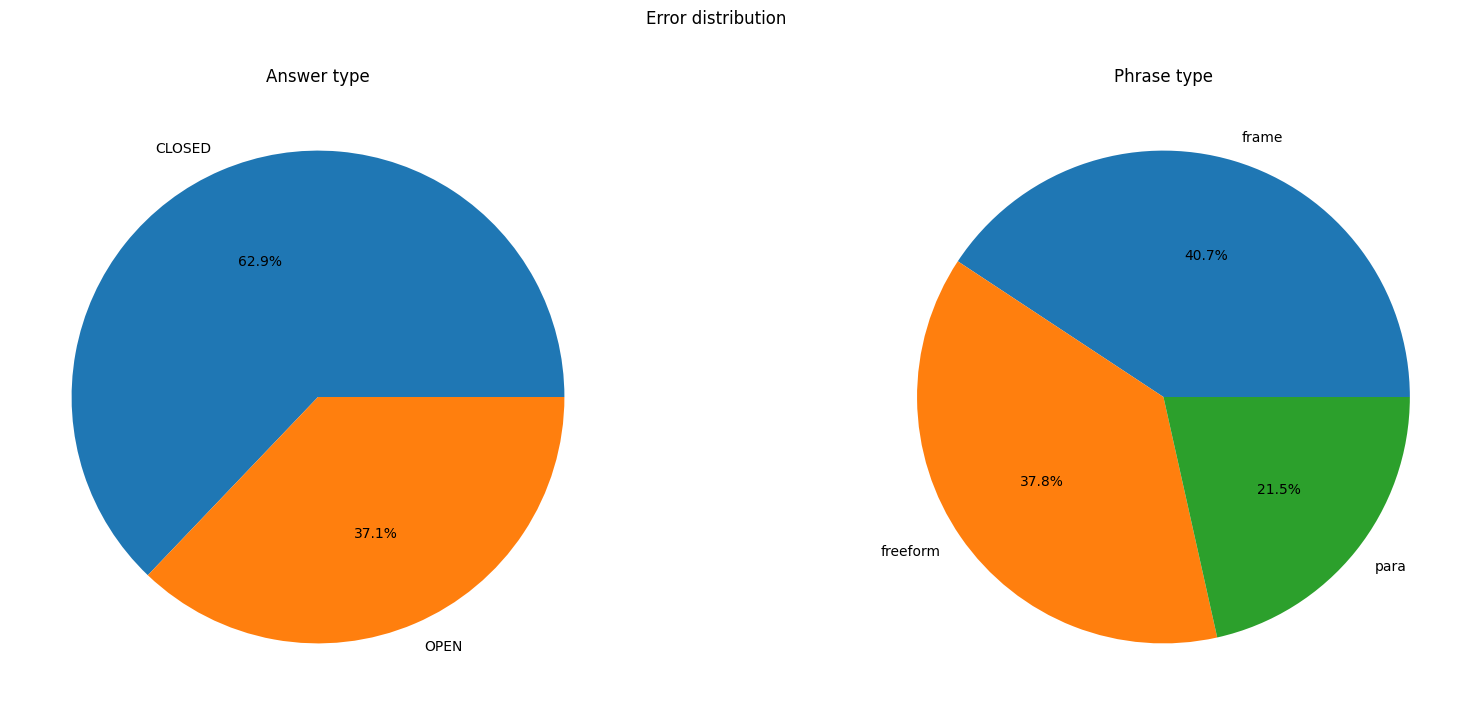

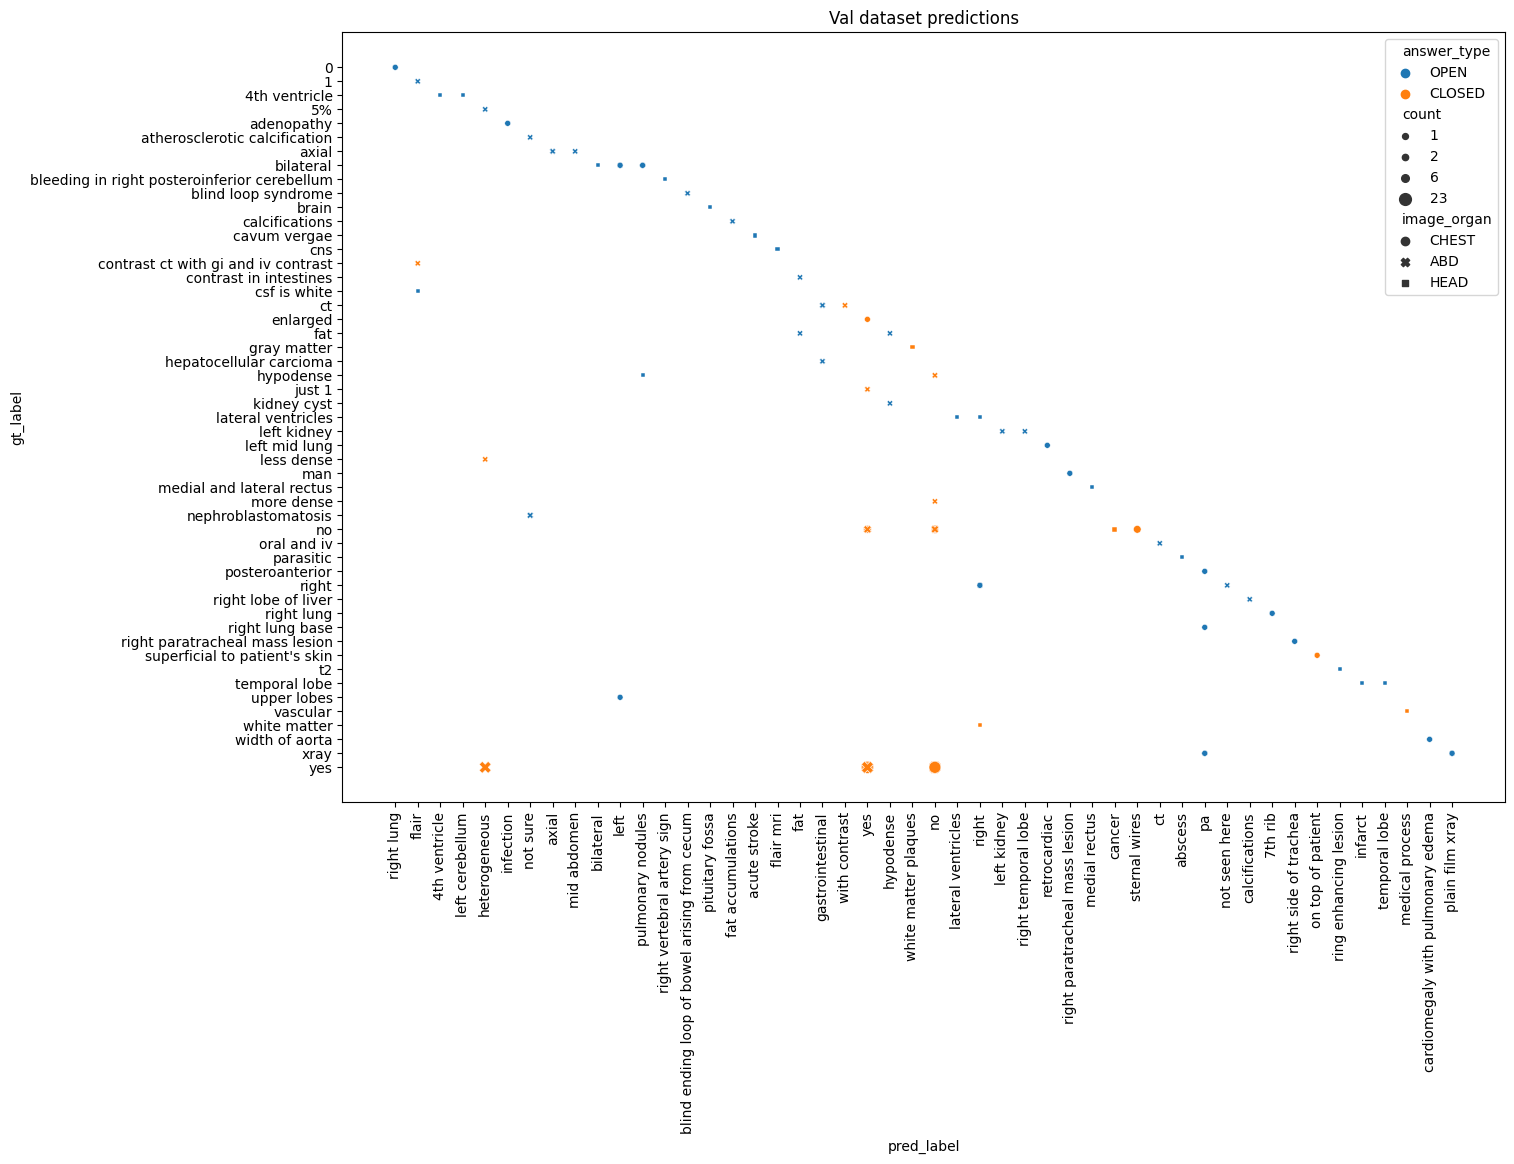

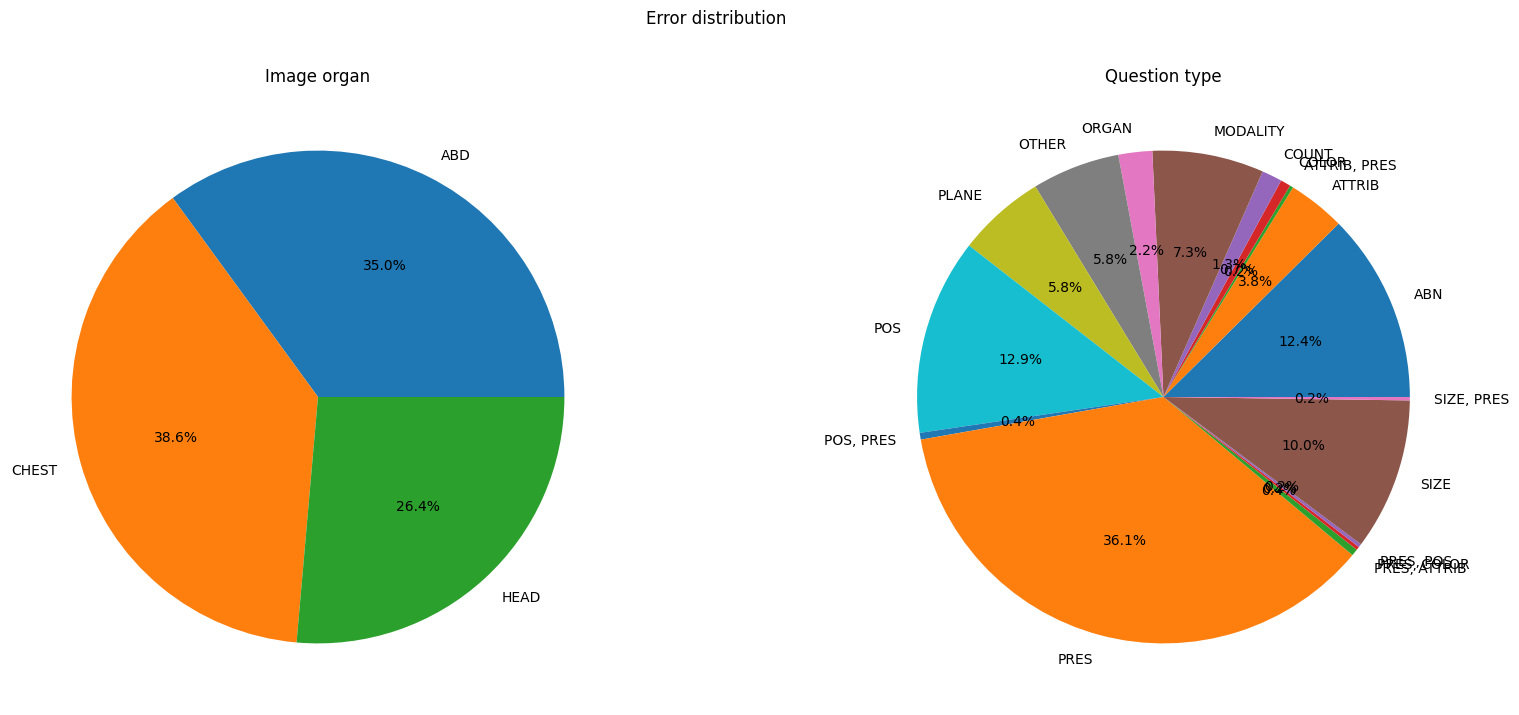

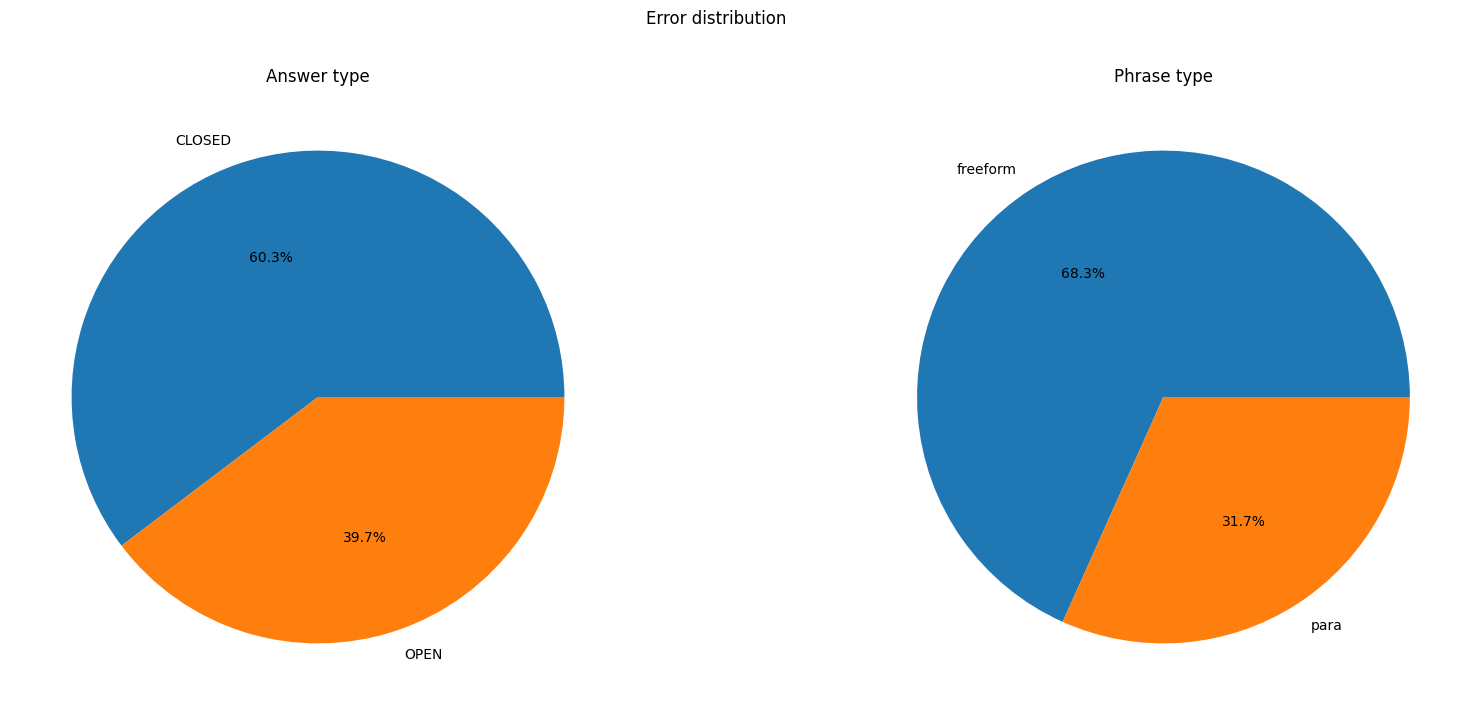

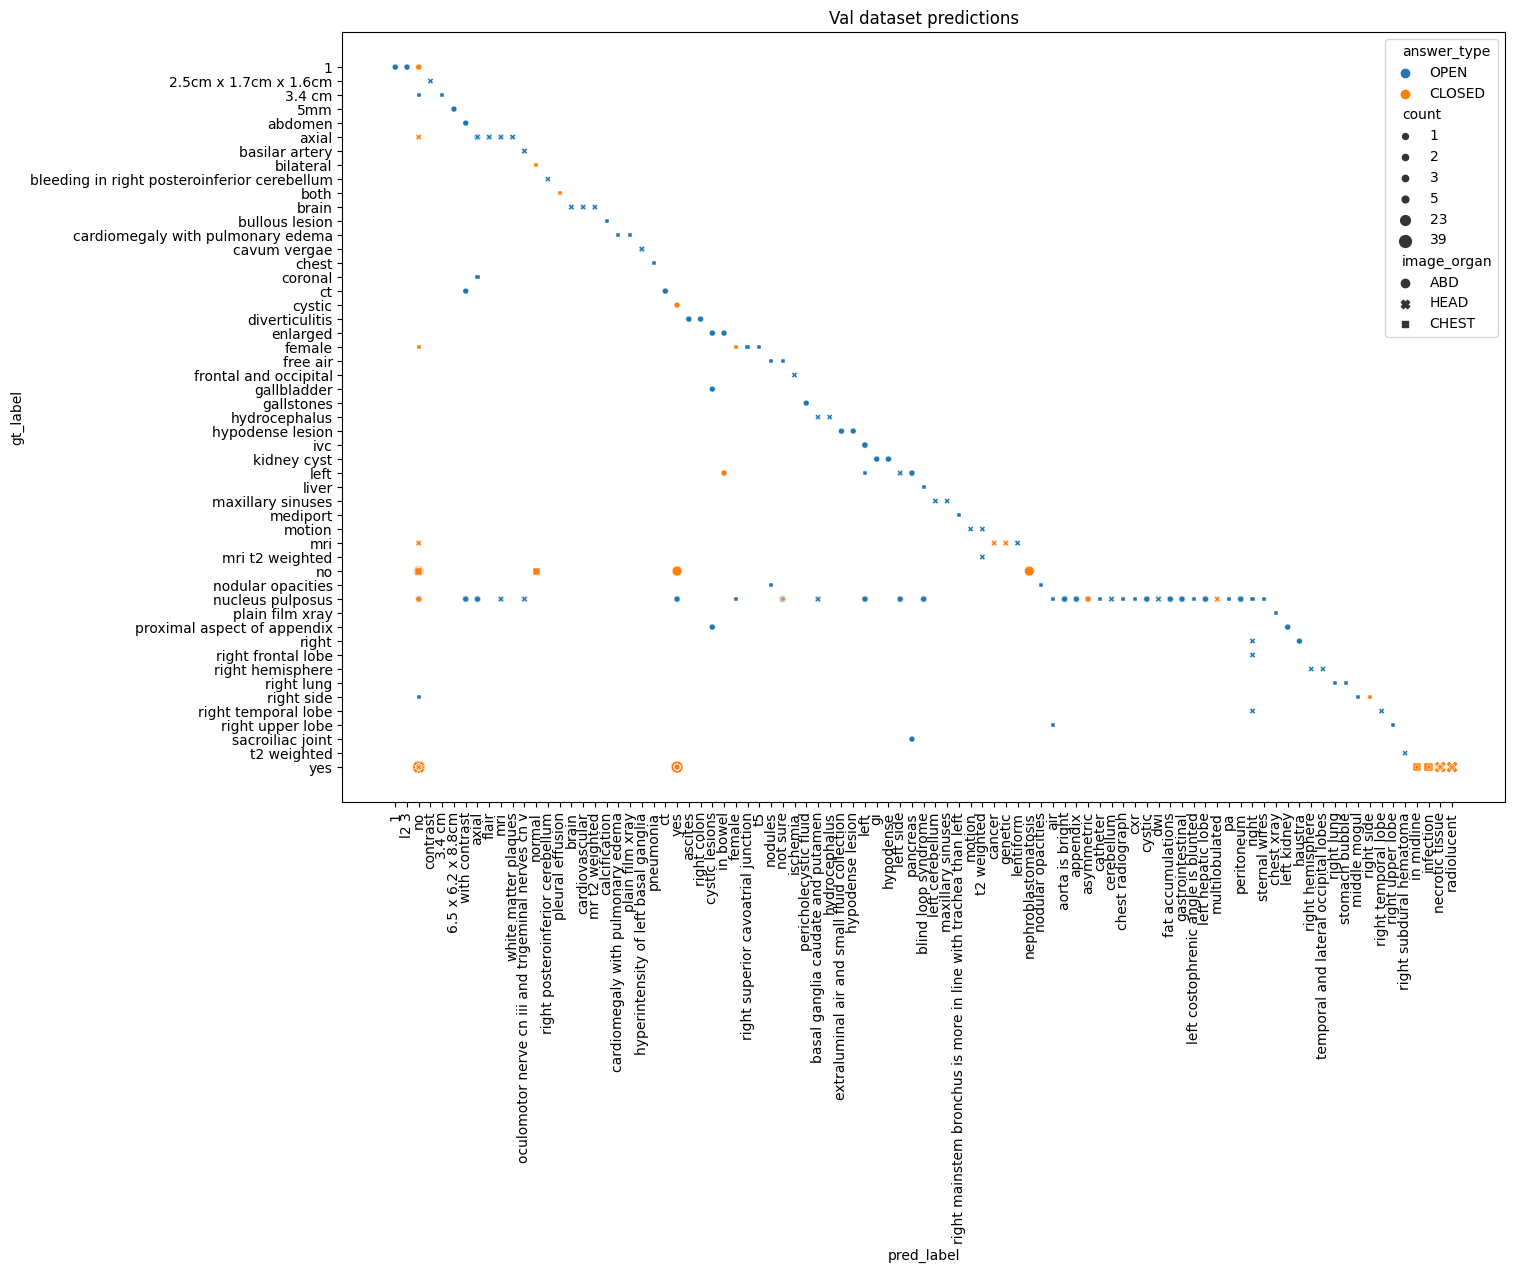

In [83]:
def pieplot(df , col_name):
    x=df.groupby([col_name]).count()
    x =x.reset_index()
    plt.pie(x['index'],labels=x[col_name] , autopct='%1.1f%%')

# def get_report(pred_list , target_list , reference_file):
orig_train_json = pd.read_json("/home/amrit/Downloads/Spring2023/pipeline/in_progress/medVQA/NLP-CS7650-Project/data/trainset.json")
val_file = pd.read_pickle("/home/amrit/Downloads/Spring2023/pipeline/in_progress/medVQA/NLP-CS7650-Project/data/cache/val.pkl")

reference_file = orig_train_json
target_list = val_gtlist
pred_list = val_predlist


def get_qid(x):
    # try:
    return val_file[x]['qid']
    # except:
    #     print(x)


df = pd.DataFrame(np.array([target_list , pred_list]).T, columns = ['gt' , 'pred'])
df['gt_label'] = df['gt'].apply(get_labels)
df['pred_label'] = df['pred'].apply(get_labels)
df = df.sort_values(['gt_label' , 'pred_label'])
df = df.reset_index()
df['qid'] = df['index'].apply(get_qid)
df = pd.merge(df, reference_file, on='qid' , how='left')

# df = get_report(val_predlist , val_gtlist  , orig_train_json)


plt.figure(figsize=(20,8))
plt.suptitle("Error distribution")
plt.subplot(1,2,1)
pieplot(df , "image_organ")
plt.title("Image organ")
plt.subplot(1,2,2)
pieplot(df , "question_type")
plt.title("Question type")
plt.show()

plt.figure(figsize=(20,8))
plt.suptitle("Error distribution")
plt.subplot(1,2,1)
pieplot(df , "answer_type")
plt.title("Answer type")
plt.subplot(1,2,2)
pieplot(df , "phrase_type")
plt.title("Phrase type")
plt.show()

false_val_df = df[df['gt_label'] !=df['pred_label']]
false_val_df.shape


false_count = false_val_df.groupby(['gt_label', 'pred_label']).count()['gt']
false_count = false_count.reset_index()
false_count['count'] = false_count['gt']
false_count = pd.merge(false_count.drop(columns="pred_label") , df, on='gt_label' , how='left')

# # false_val_df['type'] = 'others'
# # false_val_df['type'][false_val_df['gt_label'].isin(['yes','no'])] = 'Yes/No'

plt.figure(figsize=(15,10))
plt.title("Val dataset predictions")
sns.scatterplot( x=false_count['pred_label'], y = false_count['gt_label'], size=false_count['count'] ,hue=false_count['answer_type'],style = false_count['image_organ'])
plt.xticks(rotation=90)
plt.show()

    # def get_imagename(x):
    #     return val[x]['image_name']
    # def get_question(qid):
    #     return orig_train_json['question'][qid]
    # val_df['image_name'] = val_df['index'].apply(get_imagename)
    # val_df['question'] = val_df['qid'].apply(get_question)



orig_test_json = pd.read_json("/home/amrit/Downloads/Spring2023/pipeline/in_progress/medVQA/NLP-CS7650-Project/data/testset.json")
test_file = pd.read_pickle("/home/amrit/Downloads/Spring2023/pipeline/in_progress/medVQA/NLP-CS7650-Project/data/cache/test_target.pkl")
test_file += pd.read_pickle("/home/amrit/Downloads/Spring2023/pipeline/in_progress/medVQA/NLP-CS7650-Project/data/cache/test_openclose_target.pkl")

def get_qid(x):
    return test_file[x]['qid']

reference_file = orig_test_json
target_list = trainer.test_gtlist
pred_list = trainer.test_predlist


df = pd.DataFrame(np.array([target_list , pred_list]).T, columns = ['gt' , 'pred'])
df['gt_label'] = df['gt'].apply(get_labels)
df['pred_label'] = df['pred'].apply(get_labels)
df = df.sort_values(['gt_label' , 'pred_label'])
df = df.reset_index()
df['qid'] = df['index'].apply(get_qid)
df = pd.merge(df, reference_file, on='qid' , how='left')

plt.figure(figsize=(20,8))
plt.suptitle("Error distribution")
plt.subplot(1,2,1)
pieplot(df , "image_organ")
plt.title("Image organ")
plt.subplot(1,2,2)
pieplot(df , "question_type")
plt.title("Question type")
plt.show()

plt.figure(figsize=(20,8))
plt.suptitle("Error distribution")
plt.subplot(1,2,1)
pieplot(df , "answer_type")
plt.title("Answer type")
plt.subplot(1,2,2)
pieplot(df , "phrase_type")
plt.title("Phrase type")
plt.show()

false_val_df = df[df['gt_label'] !=df['pred_label']]
false_val_df.shape


false_count = false_val_df.groupby(['gt_label', 'pred_label']).count()['gt']
false_count = false_count.reset_index()
false_count['count'] = false_count['gt']
false_count = pd.merge(false_count.drop(columns="pred_label") , df, on='gt_label' , how='left')

# # false_val_df['type'] = 'others'
# # false_val_df['type'][false_val_df['gt_label'].isin(['yes','no'])] = 'Yes/No'

plt.figure(figsize=(15,10))
plt.title("Val dataset predictions")
sns.scatterplot( x=false_count['pred_label'], y = false_count['gt_label'], size=false_count['count'] ,hue=false_count['answer_type'],style = false_count['image_organ'])
plt.xticks(rotation=90)
plt.show()

# Extras

train_df = pd.DataFrame(np.array([train_gtlist , train_predList]).T, columns = ['gt' , 'pred'])

train_df['gt_label'] = train_df['gt'].apply(get_labels)
train_df['pred_label'] = train_df['pred'].apply(get_labels)
train_df

train_df['gt_label'].unique()
#train_df.groupby(['gt_label']).count()